In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import plot_tree
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsRegressor

# Load data

In [2]:
df = pd.read_csv('../data/processed.csv')

In [3]:
df

,Institution,Course,actor.id,timestamp,verb.id,object.definition.type,result.score.scaled,result.success,result.completion,Teaching
0,UEF,Advanced Data Management Systems,0,2023-07-07 18:55:47,viewed,course,NaN,False,False,Flipped classroom
1,UEF,Advanced Data Management Systems,0,2023-07-07 15:21:18,viewed,link,NaN,False,False,Flipped classroom
2,UEF,Advanced Data Management Systems,0,2023-07-07 15:08:13,viewed,link,NaN,False,False,Flipped classroom
3,UEF,Advanced Data Management Systems,0,2023-07-07 15:08:10,viewed,course,NaN,False,False,Flipped classroom
4,UEF,Advanced Data Management Systems,0,2023-07-07 09:03:32,viewed,course,NaN,False,False,Flipped classroom
...,...,...,...,...,...,...,...,...,...,...
299286,BMU,Computer Networks,820,2023-06-11 22:57:27,answered,cmi.interaction,1.000,True,True,Flipped classroom
299287,BMU,Computer Networks,799,2023-05-16 00:05:45,answered,cmi.interaction,0.000,False,True,Flipped classroom
299288,BMU,Computer Networks,788,2023-05-12 22:10:50,completed,assessment,0.375,True,True,Flipped classroom
299289,BMU,Computer Networks,788,2023-02-27 22:45:33,completed,module,NaN,False,False,Flipped classroom


# Regression preprocess

In [4]:
df_reg = pd.get_dummies(df['Course']).astype(int)

In [5]:
df_reg = pd.concat([df_reg, pd.get_dummies(df['Teaching']).astype(int)], axis=1)

In [6]:
df_reg

,Advanced Data Management Systems,Computer Architecture,Computer Networks,Computer Organization,Human Factors of Interactive Technology,Human-computer interaction,Web Applications,e-Learning,Flipped classroom,Project-based
0,1,0,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,0,0,1,0
2,1,0,0,0,0,0,0,0,1,0
3,1,0,0,0,0,0,0,0,1,0
4,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
299286,0,0,1,0,0,0,0,0,1,0
299287,0,0,1,0,0,0,0,0,1,0
299288,0,0,1,0,0,0,0,0,1,0
299289,0,0,1,0,0,0,0,0,1,0


In [7]:
df_reg['actor.id'] = df['actor.id'] 

In [8]:
df_reg = df_reg.groupby('actor.id').max()

In [9]:
df_object_by_actor = df.groupby('actor.id')['object.definition.type'].value_counts().unstack(fill_value=0).stack().reset_index()

In [10]:
df_object_by_actor

,actor.id,object.definition.type,0
0,0,assessment,0
1,0,attempt,0
2,0,cmi.interaction,0
3,0,course,4
4,0,discussion,0
...,...,...,...
12430,828,page,0
12431,828,quiz,2
12432,828,resource,0
12433,828,review,0


In [11]:
df_object_by_actor = pd.concat([
     pd.Series(v.values, name=k) for k, v in df_object_by_actor.groupby('object.definition.type')[0]
    ], 
    axis=1
)

In [12]:
df_object_by_actor

,assessment,attempt,cmi.interaction,course,discussion,forum-topic,lesson,link,meeting,module,page,quiz,resource,review,survey
0,0,0,0,4,0,0,0,2,0,0,0,0,0,0,0
1,0,0,0,9,0,0,0,0,0,0,0,0,0,0,0
2,23,9,0,379,1,1,0,46,0,0,0,0,5,0,0
3,51,13,80,49,0,0,0,41,0,14,0,0,6,12,0
4,30,4,10,116,0,0,0,54,0,6,0,0,5,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
824,28,0,44,0,0,0,0,0,0,9,0,10,0,0,0
825,26,0,44,0,0,0,0,0,0,8,0,10,0,0,0
826,4,0,6,0,0,0,0,0,0,1,0,2,0,0,0
827,4,0,16,0,0,0,0,0,0,0,0,4,0,0,0


In [13]:
df_object_by_actor

,assessment,attempt,cmi.interaction,course,discussion,forum-topic,lesson,link,meeting,module,page,quiz,resource,review,survey
0,0,0,0,4,0,0,0,2,0,0,0,0,0,0,0
1,0,0,0,9,0,0,0,0,0,0,0,0,0,0,0
2,23,9,0,379,1,1,0,46,0,0,0,0,5,0,0
3,51,13,80,49,0,0,0,41,0,14,0,0,6,12,0
4,30,4,10,116,0,0,0,54,0,6,0,0,5,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
824,28,0,44,0,0,0,0,0,0,9,0,10,0,0,0
825,26,0,44,0,0,0,0,0,0,8,0,10,0,0,0
826,4,0,6,0,0,0,0,0,0,1,0,2,0,0,0
827,4,0,16,0,0,0,0,0,0,0,0,4,0,0,0


In [14]:
df_reg = pd.concat([df_reg, df_object_by_actor], axis=1)

In [15]:
df_reg['score'] = df.groupby('actor.id')['result.score.scaled'].mean()

In [16]:
df_reg.describe()

,Advanced Data Management Systems,Computer Architecture,Computer Networks,Computer Organization,Human Factors of Interactive Technology,Human-computer interaction,Web Applications,e-Learning,Flipped classroom,Project-based,...,lesson,link,meeting,module,page,quiz,resource,review,survey,score
count,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000,...,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000,763.000000
mean,0.098914,0.119421,0.049457,0.095296,0.312425,0.144753,0.080820,0.098914,0.366707,0.633293,...,0.007238,12.401689,0.237636,28.755127,3.089264,25.431846,37.141134,2.800965,0.106152,0.786952
std,0.298727,0.324479,0.216951,0.293800,0.463762,0.352064,0.272723,0.298727,0.482196,0.482196,...,0.155249,19.852939,1.546457,47.042807,5.668946,64.136172,47.217025,4.328336,0.453993,0.260776
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,7.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.740000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,3.000000,0.000000,16.000000,0.000000,0.000000,21.000000,0.000000,0.000000,0.868750
75%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,16.000000,0.000000,42.000000,5.000000,10.000000,54.000000,6.000000,0.000000,0.967500
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,4.000000,133.000000,21.000000,1100.000000,63.000000,427.000000,377.000000,30.000000,5.000000,1.000000


In [17]:
df_reg = df_reg.loc[df_reg['score'].notnull()].reset_index().drop(columns=['index', 'lesson'], axis=1)

In [18]:
df_reg

,Advanced Data Management Systems,Computer Architecture,Computer Networks,Computer Organization,Human Factors of Interactive Technology,Human-computer interaction,Web Applications,e-Learning,Flipped classroom,Project-based,...,forum-topic,link,meeting,module,page,quiz,resource,review,survey,score
0,1,0,0,0,0,0,0,0,1,0,...,0,41,0,14,0,0,6,12,0,0.947059
1,1,0,0,0,0,0,0,0,1,0,...,0,54,0,6,0,0,5,2,0,0.842000
2,1,0,0,0,0,0,0,0,1,0,...,1,54,0,15,0,0,6,7,0,0.966250
3,1,0,0,0,0,0,0,0,1,0,...,2,53,0,15,0,0,8,7,0,0.926667
4,1,0,0,0,0,0,0,0,1,0,...,0,24,0,8,0,0,5,9,0,0.971429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
758,0,0,1,0,0,0,0,0,1,0,...,0,0,0,9,0,10,0,0,0,0.691810
759,0,0,1,0,0,0,0,0,1,0,...,0,0,0,8,0,10,0,0,0,0.772076
760,0,0,1,0,0,0,0,0,1,0,...,0,0,0,1,0,2,0,0,0,0.357143
761,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,4,0,0,0,0.935294


<Axes: >

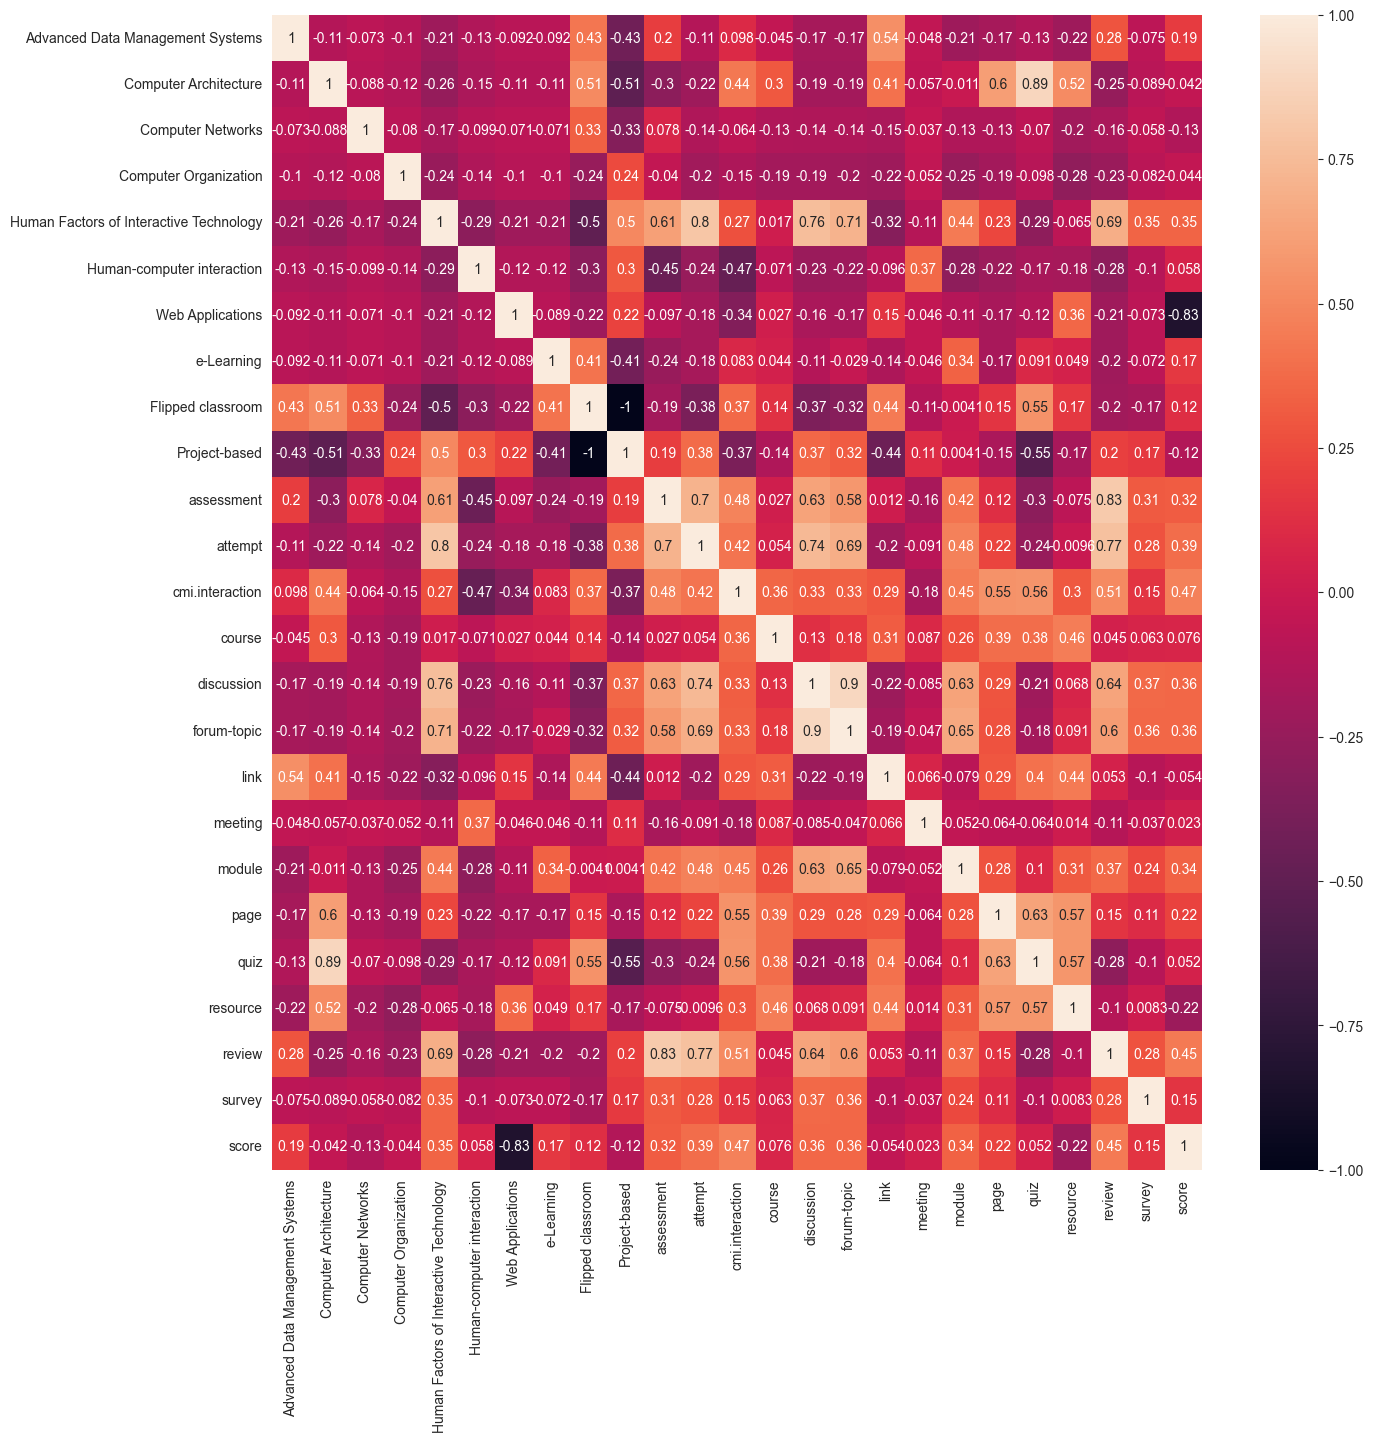

In [19]:
plt.figure(figsize=(15, 15))
sns.heatmap(df_reg.corr(), annot=True)

# Regression

In [20]:
def regression_results(y_true, y_pred):
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [21]:
X = df_reg.drop('score', axis=1)
y = df_reg['score']

In [22]:
X_columns = X.columns.tolist()

In [23]:
X

,Advanced Data Management Systems,Computer Architecture,Computer Networks,Computer Organization,Human Factors of Interactive Technology,Human-computer interaction,Web Applications,e-Learning,Flipped classroom,Project-based,...,discussion,forum-topic,link,meeting,module,page,quiz,resource,review,survey
0,1,0,0,0,0,0,0,0,1,0,...,0,0,41,0,14,0,0,6,12,0
1,1,0,0,0,0,0,0,0,1,0,...,0,0,54,0,6,0,0,5,2,0
2,1,0,0,0,0,0,0,0,1,0,...,2,1,54,0,15,0,0,6,7,0
3,1,0,0,0,0,0,0,0,1,0,...,0,2,53,0,15,0,0,8,7,0
4,1,0,0,0,0,0,0,0,1,0,...,0,0,24,0,8,0,0,5,9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
758,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,9,0,10,0,0,0
759,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,8,0,10,0,0,0
760,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,2,0,0,0
761,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,4,0,0,0


In [24]:
X = preprocessing.normalize(X)

In [25]:
y

0      0.947059
1      0.842000
2      0.966250
3      0.926667
4      0.971429
         ...   
758    0.691810
759    0.772076
760    0.357143
761    0.935294
762    0.500000
Name: score, Length: 763, dtype: float64

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [27]:
regression_1 = LinearRegression()

In [28]:
regression_1.fit(X_train, y_train)

LinearRegression()

In [29]:
regression_1.score(X_train, y_train)

0.6208184410433263

In [30]:
coef_df= pd.DataFrame(zip(regression_1.coef_, X_columns))
coef_df

,0,1
0,3.285259,Advanced Data Management Systems
1,-9.352278,Computer Architecture
2,-1.998566,Computer Networks
3,0.807795,Computer Organization
4,1.400161,Human Factors of Interactive Technology
5,3.988357,Human-computer interaction
6,-7.753133,Web Applications
7,7.130911,e-Learning
8,-0.934674,Flipped classroom
9,-1.556821,Project-based


In [31]:
regression_1.intercept_

0.5023278443866064

In [32]:
y_pred = regression_1.predict(X_test)

In [33]:
regression_results(y_test, y_pred)

explained_variance:  0.5847
r2:  0.5821
MAE:  0.1255
MSE:  0.0293
RMSE:  0.1711


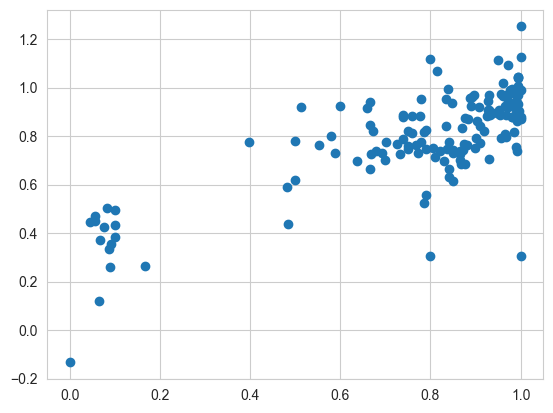

In [34]:
plt.scatter(y_test, y_pred)

[]

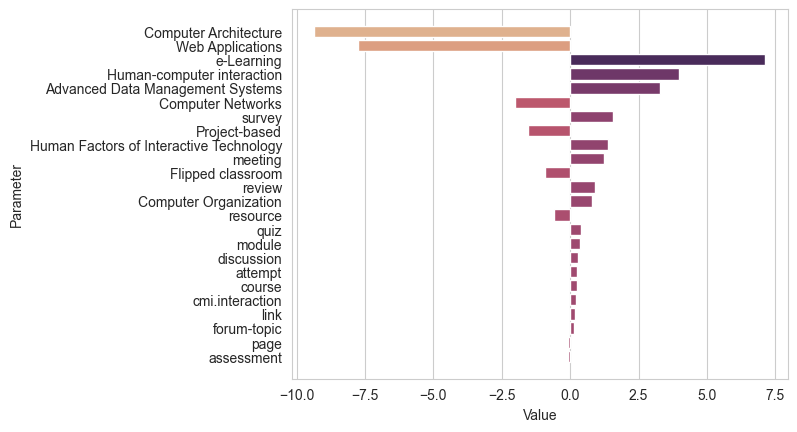

In [35]:
coeff = coef_df.iloc[(coef_df[0].abs()*-1.0).argsort()]
sns.barplot(x=coeff[0], y=coeff[1], orient='h', palette='flare', hue=coeff[0], legend=None)
plt.xlabel('Value')
plt.ylabel('Parameter')
plt.plot()

# Decision Tree Regressor

In [36]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(random_state = 0)

In [37]:
model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=0)

In [38]:
y_pred = model.predict(X_test)

rmse = float(format(np.sqrt(mean_squared_error(y_test, y_pred)), '.3f'))
rmse

0.117

In [39]:
r2_score(y_test, y_pred)

0.80601517683437

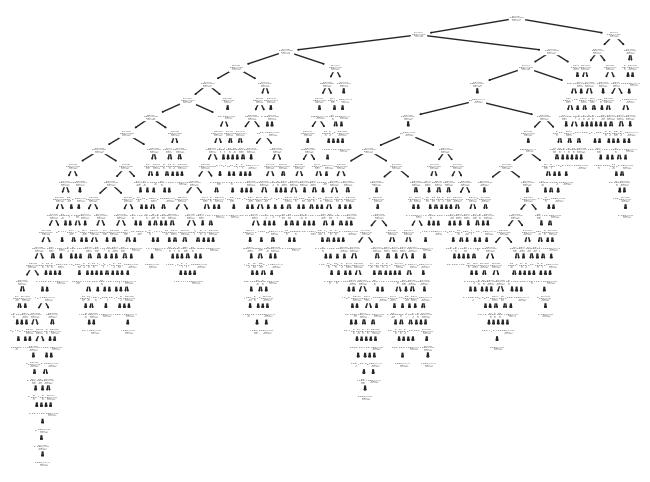

In [40]:
_, ax = plt.subplots(figsize=(8, 6))
_ = plot_tree(model, ax=ax)

In [41]:
grid_search_params = {
    'max_depth': [3, 5, 7, 9, 11, 15] + [None],
    'max_features': ["sqrt", "log2", None],
    'min_samples_leaf': [1, 3, 5],
    'min_samples_split': [2, 3, 4],
    'criterion': ["squared_error", "friedman_mse", "absolute_error", "poisson"],
    'splitter': ["best", "random"]
}

In [42]:
grid_search = GridSearchCV(
    estimator = DecisionTreeRegressor(),
    param_grid = grid_search_params,
    cv=10,
    verbose=2,
    scoring='r2',
    n_jobs = -1
)
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 1512 candidates, totalling 15120 fits


GridSearchCV(cv=10, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'criterion': ['squared_error', 'friedman_mse',
                                       'absolute_error', 'poisson'],
                         'max_depth': [3, 5, 7, 9, 11, 15, None],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [2, 3, 4],
                         'splitter': ['best', 'random']},
             scoring='r2', verbose=2)

In [43]:
grid_search.best_params_

{'criterion': 'squared_error',
 'max_depth': 5,
 'max_features': None,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'splitter': 'best'}

In [44]:
model = DecisionTreeRegressor(
    max_depth=5,
    max_features=None,
    min_samples_leaf=1,
    min_samples_split=3,
    criterion='squared_error',
    splitter='random'
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

r2_score(y_test, y_pred)

0.7639062370066376

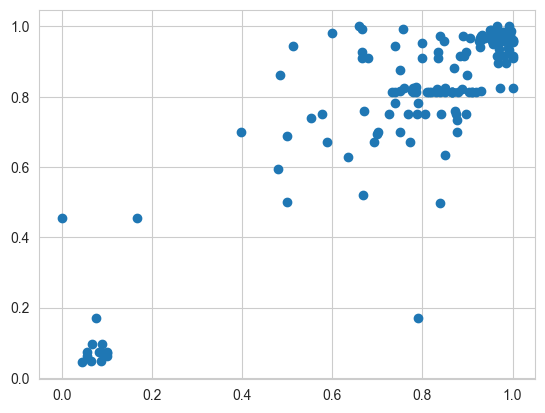

In [45]:
plt.scatter(y_test, y_pred)

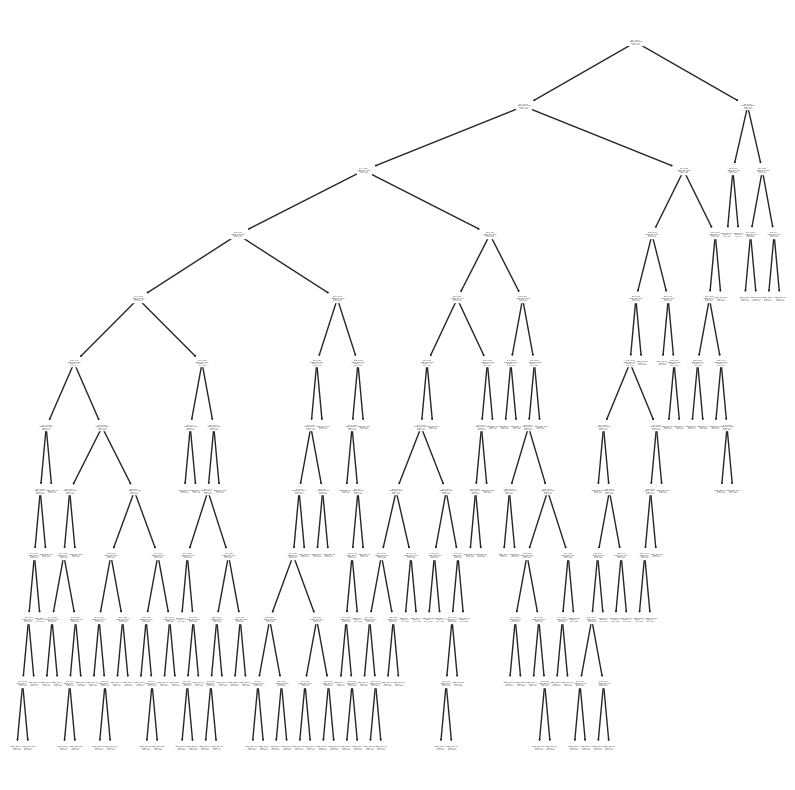

In [46]:
_, ax = plt.subplots(figsize=(10, 10))
_ = plot_tree(model, ax=ax)

# k-NN Regressor

In [47]:
model = KNeighborsRegressor().fit(X_train, y_train)

In [48]:
y_pred = model.predict(X_test)

In [49]:
print("Mean Squared Error = ", mean_squared_error(y_pred, y_test))
print("Root Mean Squared Error = ", np.sqrt(mean_squared_error(y_pred, y_test)))

Mean Squared Error =  0.031435093894838596
Root Mean Squared Error =  0.17729944696709743


In [50]:
r2_score(y_test, y_pred)

0.5514717777208374

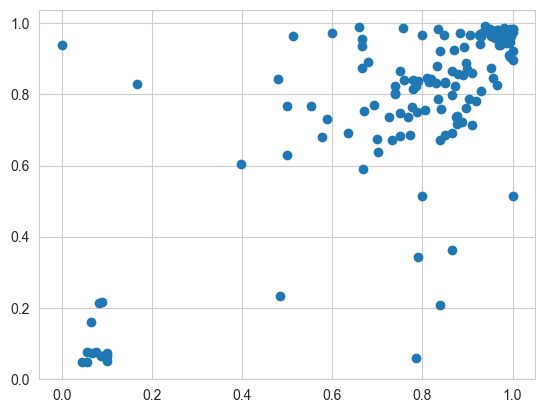

In [51]:
plt.scatter(y_test, y_pred)